**Creating multi-class classification data**

In [19]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd

In [20]:


# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
x_blob, y_blob = make_blobs(n_samples=1000,
  n_features=NUM_FEATURES, # X features
  centers=NUM_CLASSES, # y labels 
  cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
  random_state=RANDOM_SEED
)

# 2. Turn data into tensors
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(x_blob[:5], y_blob[:5])

# 3. Split into train and test sets
x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,
  y_blob,
  test_size=0.2,
  random_state=RANDOM_SEED
)

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


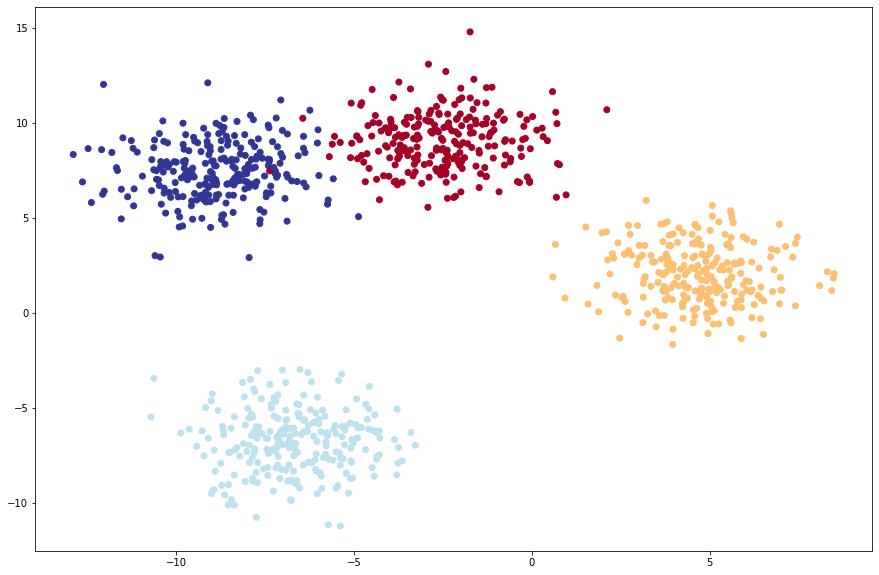

In [21]:
# Visualize with a plot
plt.figure(figsize=(15,10))
plt.scatter(x=x_blob[:, 0], y=x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

**Building a multi-class classification model in PyTorch**

In [22]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes all required hyperparameters for a multi-class classification model.

      Args:
          input_features (int): Number of input features to the model.
          out_features (int): Number of output features of the model
            (how many classes there are).
          hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
      )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [24]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

**Creating a loss function and optimizer for a multi-class PyTorch model**

In [25]:
# Now make a dataframe to see the unique value counts
data_df = pd.DataFrame({"x1":x_blob[:,0],"x2":x_blob[:,1],"label":y_blob})
data_df

,x1,x2,label
0,-8.413396,6.935165,3
1,-5.766484,-6.431171,2
2,-6.042137,-6.766101,2
3,3.950837,0.698403,1
4,4.250492,-0.281545,1
...,...,...,...
995,-3.787372,-5.067560,2
996,-1.573018,9.956804,0
997,3.215780,5.921743,1
998,-7.793896,-7.160566,2


In [26]:
data_df.label.value_counts()

3    250
2    250
1    250
0    250
Name: label, dtype: int64

In [27]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

**Getting prediction probabilities for a multi-class PyTorch model**

In [37]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(x_blob_test.to(device))
y_preds[:10]

tensor([[ 0.0539, -0.2127, -0.3576,  0.1295],
        [ 0.6093, -1.0669, -0.3753, -0.4278],
        [ 0.9798, -0.0074,  0.3320, -0.6289],
        [ 0.1105,  0.0372, -0.1663,  0.1137],
        [ 0.4959, -1.0888, -0.3754, -0.4434],
        [ 0.6878, -1.2385, -0.4357, -0.5246],
        [ 0.9936, -0.1752,  0.2670, -0.7394],
        [ 0.5006, -1.0835, -0.3803, -0.4688],
        [ 1.0828,  0.1954,  0.4707, -0.5672],
        [ 0.4923, -1.0669, -0.3722, -0.4496]], device='cuda:0')